In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

In [2]:
# import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline


from sklearn.decomposition import TruncatedSVD


In [3]:
threshold = 0.5 # confidence in sentiment threshold 

def process_string(s):
    # Split the string on spaces
    words = s.split()
    
    # Remove first element
    words.pop(0)
    
    # Rejoin the list into a string
    return ' '.join(words)


df = pd.read_csv('AirlineTweets.csv',delimiter=",")
df = df[df['airline_sentiment_confidence']>threshold]
df = df[['airline_sentiment','text']]

# Apply the function to each row in the DataFrame
df['text'] = df['text'].apply(process_string)

sentiment = df["airline_sentiment"]
text = df["text"]

# Display the first few rows of the DataFrame
print(df.head())
print(f"Number of samples: {len(df)}")

## Convert classes to numbers
#target_map = {"pos":1,"neg":0,"neut":2}
#df['airline_sentiment'] = df['airline_sentiment'].map(target_map)


  airline_sentiment                                               text
0           neutral                               What @dhepburn said.
2           neutral  I didn't today... Must mean I need to take ano...
3          negative  it's really aggressive to blast obnoxious "ent...
4          negative           and it's a really big bad thing about it
5          negative  seriously would pay $30 a flight for seats tha...
Number of samples: 14404


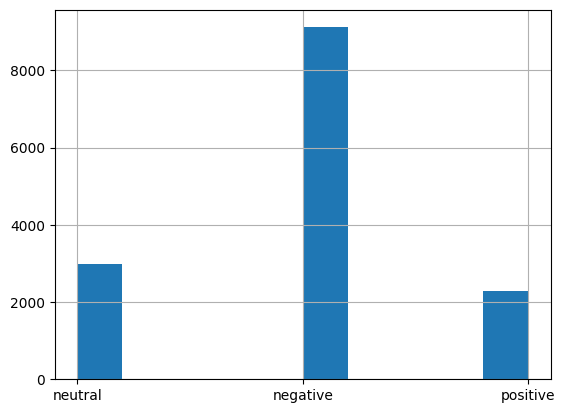

In [4]:
#TODO: create a function that splits the data but keeps the same percentage of each class in both train and test
# Check for class imbalance

test_plots = df['airline_sentiment'].hist()

In [ ]:

#### MIGHT BE WORKING BUT MY BRAIN IS FRYED RN,
#### DONT RUN THIS FOR NOW :)

X_train, X_test, y_train, y_test = train_test_split(text, sentiment, test_size=0.3, random_state=42)


tfidf_vectorizer = TfidfVectorizer(lowercase=True)

# function .fit_transform() trains on a new vocabulary, 
# while .transform() trains on existing vocabulary
X_train_vect = tfidf_vectorizer.fit_transform(X_train)
X_test_vect = tfidf_vectorizer.transform(X_test)


svd = TruncatedSVD(n_components=100)

Z_train = svd.fit_transform(X_train_vect.T)
Z_test = svd.transform(X_test_vect.T)

print(Z_train.shape)
print(Z_test.shape)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(text, sentiment, test_size=0.3, random_state=42)


tfidf_vectorizer = TfidfVectorizer(lowercase=True)
svd = TruncatedSVD(n_components=100)

# Create a pipeline that combines TfidfVectorizer and TruncatedSVD
pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('svd', svd)
])

# Fit and transform the training data
Z_train_svd = pipeline.fit_transform(X_train)

# Transform the test data
Z_test_svd = pipeline.transform(X_test)

In [6]:
print(Z_train_svd.shape)
print(y_train.shape)

(10082, 100)
(10082,)


In [9]:
# Train a logistic regression model
model = LogisticRegression(max_iter=1000,class_weight='balanced')
model.fit(Z_train_svd, y_train)
print("Model train acc:",model.score(Z_train_svd,y_train))
print("Model test acc:",model.score(Z_test_svd,y_test))

Model train acc: 0.7116643523110494
Model test acc: 0.7161036557149468


In [12]:
preds = model.predict_proba(Z_test_svd)
probs = ["negative","neuteral","positive"]

negative_sentiment = {}
neuteral_sentiment = {}
positive_sentiment = {}


for i,pred in enumerate(preds):
  
    index = np.argmax(pred)
    
    if index == 0:
        negative_sentiment[X_test.iloc[i]] = pred[index]
    
    if index == 1:
        neuteral_sentiment[X_test.iloc[i]] = pred[index]
    
    if index == 2:
        positive_sentiment[X_test.iloc[i]] = pred[index]
    
        
# get most positive review
max_key = max(positive_sentiment, key=positive_sentiment.get)
print(max_key)
print(positive_sentiment[max_key])


# get most negative review
max_key = max(negative_sentiment, key=negative_sentiment.get)
print(max_key)
print(negative_sentiment[max_key])



Great - thank you.
0.9999194824393836
no your not!
0.9991314671145068


In [16]:
# Sample custom text for prediction
custom_text = ["it was mid", "it was awesome","worst ever"]

# Transform the custom text using the same vectorizer
custom_text_vectorized = pipeline.transform(custom_text)

# Make the prediction
predictions = model.predict(custom_text_vectorized)

# Display the predictions
for text, prediction in zip(custom_text, predictions):
    print(f"Text: {text}\nPrediction: {prediction}\n")

Text: it was mid
Prediction: positive

Text: it was awesome
Prediction: positive

Text: worst ever
Prediction: negative



In [18]:
#Calculate AUC Score
P_train = model.predict_proba(Z_train_svd)
P_test = model.predict_proba(Z_test_svd)
print("Train AUC:",roc_auc_score(y_train,P_train,multi_class='ovo'))
print("Test AUC:",roc_auc_score(y_test,P_test,multi_class='ovo'))


Train AUC: 0.8716595218008895
Test AUC: 0.8648513933576482


In [19]:
cm = confusion_matrix(y_test,P_test,normalize='true')

sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=probs, yticklabels=probs)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets